I'm going to explore multi-dimensional inputs and outputs in this notebook.

We're going to have $y = y(y_{0}, y_{1}, ..., y_{n})$, and $x = x(x_{0}, x_{1}, ..., x_{n})$. For simplicity's sake, let $n = 1$.

I'm also going to assume each parameter of $x$ is mapped to its corresponding $y$ parameter: as in,

$x_{0} \rightarrow y_{0}$, and  $x_{1} \rightarrow y_{1}$.

There'll be functions mapping each input to its corresponding output, of course, for example,

$y_{0} = x_{0}^{2}$, and $y_{1} = x_{1}^{4}$.

I'm going to use more complex functions to strain the model a little more, but the real challenge is plotting these, because

$x = [x_{0} \; x_{1}]$, and $y = [y_{0} \; y_{1}]$.

A neural network usually has one output layer. I'm going to have to branch out the layer this time, such that each y-element has an output layer.

Also, I'm going to use a dropout probability of 0.3, since, from the dropouts notebook, that seems to be the optimal choice.

With that, I'll get started.

In [32]:
#importing libraries
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [33]:
#allocating datasets and model to GPU for speed's sake
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Since I'm working with multi-dimensional inputs and outputs, the model architecture has to change to accommodate the new dataset's properties.

In [34]:
class DualOutputBNN(nn.Module):
    def __init__(self, no_of_neurones, dropout_prob):
        super(DualOutputBNN, self).__init__()
        self.shared_layer = nn.Sequential(
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            # bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            # nn.ReLU(),
            # nn.Dropout(dropout_prob)
        )
        # self.output_layer_y0 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=1)
        # self.output_layer_y1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=1)
        self.output_layer_y0 = nn.Sequential(
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=1)
        )
        self.output_layer_y1 = nn.Sequential(
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=1)
        )


    def forward(self, x):
        shared = self.shared_layer(x)
        y0 = self.output_layer_y0(shared)
        y1 = self.output_layer_y1(shared)
        return y0, y1

I'll now write a function to initialise the model above, in the same way that I did in previous notebooks.

In [35]:
def initialise_model(no_of_neurones: int, dropout_prob: float, lr: float = 0.01) -> tuple:
    """
    Initialise the DualOutputBNN model with its loss functions and optimizer.

    Parameters:
    - no_of_neurones (int): Number of neurons in the hidden layer.
    - dropout_prob (float): Dropout probability.
    - lr (float): Learning rate for the optimizer. Default is 0.01.

    Returns:
    - A tuple containing the initialized model, MSE loss function, KL loss function, KL weight, and optimizer.
    """

    model = DualOutputBNN(no_of_neurones, dropout_prob).to(device)

    mse_loss = nn.MSELoss().to(device)
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
    kl_weight = 0.01

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    return model, mse_loss, kl_loss, kl_weight, optimizer



In [36]:
def train_model(model_attributes, x_train, y_train, epochs: int):
    """
    Train a Bayesian Neural Network model for a specified number of epochs.

    Parameters:
    - model_attributes: A tuple containing the model, loss functions, kl_weight, and optimizer.
    - x_train (torch.Tensor): Input tensor for the training data.
    - y_train (torch.Tensor): Target tensor for the training data.
    - epochs (int): Number of epochs to train the model.

    Returns:
    - model (torch.nn.Sequential): The trained neural network model.

    Ensures that training data and model are on the same device for efficiency.
    """
    print("Running Training...")

    model, mse_loss, kl_loss, kl_weight, optimizer = model_attributes
    model.train()

    print(x_train.shape, y_train.shape)
    print(y_train[:,0].shape, y_train[:,1].shape)

    print("The warning appears here.")
    for _ in range(epochs):
        y0_pred, y1_pred = model(x_train)
        y0_mse, y1_mse = mse_loss(y0_pred, torch.unsqueeze(torch.Tensor(y_train[:,0]), dim=1)), mse_loss(y1_pred, torch.unsqueeze(torch.Tensor(y_train[:,1]), dim=1))
        kl = kl_loss(model)
        y0_cost, y1_cost = y0_mse + kl_weight * kl, y1_mse + kl_weight * kl
        cost = y0_cost + y1_cost

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
    print(f"- Cost: {cost.item():.3f}")
    print("Training Complete")

    return model

Since I already produced the test set in the beginning, producing testing data in test_model() not only becomes trivial, but, with the way I produce it in the function, error-prone. I can also remove the func parameter for this reason.

The real problem is processing the produced data.

I need to:
* Predict both $y_{0}$ and $y_{1}$
* Find each output's mean_model_results and std_model_results
* Return a df: x_test, y_test, mean_model_results (for $y_{0},y_{1}$), std_model_results (for $y_{0}, y_{1}$)

So basically I'm producing a results dataframe.

In [37]:
def test_model(model, x_test):
    """
    Test a Bayesian Neural Network model to produce predictions along with mean and standard deviation.

    Parameters:
    - model (torch.nn.Sequential): The trained neural network model.
    - func (callable): The target function to compare against the model's predictions.

    Returns:
    - mean_model_results (numpy.ndarray): Array of mean predictions from the model.
    - std_model_results (numpy.ndarray): Array of standard deviations of the predictions.
    - x_test (torch.Tensor): Testing dataset inputs.
    - y_test (torch.Tensor): Testing dataset targets.

    The testing data is moved to the device specified by the global `device` variable.
    """
    print("Running Test...")

    #producing predictions of model of testing data, as well as mean and standard deviation of predictions
    model.eval().cpu()
    y0_pred, y1_pred = model(x_test)[0], model(x_test)[1]


    y0_pred, y1_pred = np.array([model(x_test)[0].detach().numpy() for _ in range(500)])[:,:,0].T, np.array([model(x_test)[1].detach().numpy() for _ in range(500)])[:,:,0].T

    mean_y0_results, std_y0_results = np.array([np.mean(y0_pred[i]) for i in range(y0_pred.shape[0])]), np.array([np.std(y0_pred[i]) for i in range(y0_pred.shape[0])])
    mean_y1_results, std_y1_results = np.array([np.mean(y1_pred[i]) for i in range(y1_pred.shape[0])]), np.array([np.std(y1_pred[i]) for i in range(y1_pred.shape[0])])

    print("Testing Complete")
    return mean_y0_results, std_y0_results, mean_y1_results, std_y1_results #!this function needs testing

My data generation will be different here. I'm going to:
* Have two linspaces: x0, x1
* Have two  functions: fx0, fx1
* Have two more linspaces: y0, y1
* Form a dataframe (df) of the four linspaces
* Use train_test_split on the df

I'll think about device applications later.

I'll also keep the functions simple:

$y_{0} = f(x_{0}) = x^{5} -7x^{2} + 4$

$y_{1} = f(x_{1}) = 3x^{2} + 2x - 5$

In [38]:
#creating dataset
x0, x1 = torch.linspace(-3, 3, 2000), torch.linspace(-3, 3, 2000)

clean_fx0 = lambda x: np.power(x, 5) - 7*np.power(x, 2) + 4
clean_fx1 = lambda x: 3*np.power(x, 2) + 2*x - 5

clean_y0, clean_y1 = clean_fx0(x0), clean_fx1(x1)
max_y0_scale, max_y1_scale = clean_y0.max()*0.2, clean_y1.max()*0.2

fx0 = lambda x0: clean_fx0(x0) + (max_y0_scale*torch.rand(x0.size()) - max_y0_scale/2)
fx1 = lambda x1: clean_fx1(x1) + (max_y1_scale*torch.rand(x1.size()) - max_y1_scale/2)

y0 = fx0(x0)
y1 = fx1(x1)

df = pd.DataFrame(
    {
        "x0":x0,
        "x1":x1,
        "y0":y0,
        "y1":y0
    }
)

x_train, x_test, y_train, y_test = train_test_split(df[["x0", "x1"]], df[["y0", "y1"]], test_size=0.2, random_state=1)

#reset indices and drop old indices of train and test sets
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

x_train = x_train.sort_values(by=['x0', 'x1'])
x_test = x_test.sort_values(by=['x0', 'x1'])

print(type(y_train["y0"]))

y_train["y0"], y_train["y1"] = fx0(torch.Tensor(x_train["x0"])), fx1(torch.Tensor(x_train["x1"]))
y_test["y0"], y_test["y1"] = fx0(torch.Tensor(x_test["x0"])), fx1(torch.Tensor(x_test["x1"]))

x_test.head()

<class 'pandas.core.series.Series'>


,x0,x1
347,-2.990995,-2.990995
244,-2.975988,-2.975988
318,-2.966984,-2.966984
354,-2.948974,-2.948974
225,-2.888944,-2.888944


Okay, the MSEs I got were ridiculous. I'm going to try and plot all of my training data.

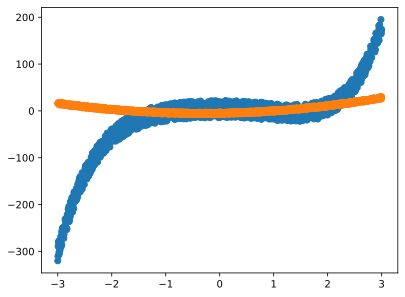

In [39]:
plt.scatter(x_train["x0"], y_train["y0"], ls="None", marker="o")
plt.scatter(x_train["x1"], y_train["y1"], ls="None", marker="o")

Okay, I've got my dataset, split it into training and testing sets, declared my model architecture, and written the function to intialise it.

What's next is to:
* Write a function to train the model
* Write a function to test the model
* Find a way to plot the model's predictions based on testing data

At some point, I should really make a class containing all of these functions so that I don't repeat them in every notebook...

In [40]:
x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)
x_train, x_test, y_train, y_test = torch.Tensor(x_train).to(device), torch.Tensor(x_test), torch.Tensor(y_train).to(device), torch.Tensor(y_test)

model_attributes = initialise_model(1000, 0.3)
model = train_model(model_attributes, x_train, y_train, 1000)

mean_y0_results, std_y0_results, mean_y1_results, std_y1_results = test_model(model, x_test)


Running Training...
torch.Size([1600, 2]) torch.Size([1600, 2])
torch.Size([1600]) torch.Size([1600])
The warning appears here.


- Cost: 277.294
Training Complete
Running Test...
Testing Complete


In [41]:
mse_loss = nn.MSELoss().to(device)
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
kl_weight = 0.01

mean_y0_mse, mean_y1_mse = mse_loss(torch.Tensor(mean_y0_results), y_test[:,0]), mse_loss(torch.Tensor(mean_y1_results), y_test[:,1])

print(f"mean_y0_mse: {mean_y0_mse}, mean_y1_mse: {mean_y1_mse}")

mean_y0_mse: 168.85186767578125, mean_y1_mse: 3.103916645050049


torch.Size([400, 2])
tensor([-2.9910e+00, -2.9760e+00, -2.9670e+00, -2.9490e+00, -2.8889e+00,
        -2.8589e+00, -2.8559e+00, -2.8529e+00, -2.8409e+00, -2.8319e+00,
        -2.8199e+00, -2.8049e+00, -2.7749e+00, -2.7539e+00, -2.7389e+00,
        -2.7269e+00, -2.7059e+00, -2.6938e+00, -2.6878e+00, -2.6788e+00,
        -2.6758e+00, -2.6668e+00, -2.6428e+00, -2.6398e+00, -2.6218e+00,
        -2.6008e+00, -2.5888e+00, -2.5798e+00, -2.5258e+00, -2.5168e+00,
        -2.5048e+00, -2.4987e+00, -2.4927e+00, -2.4687e+00, -2.4567e+00,
        -2.4417e+00, -2.4297e+00, -2.4237e+00, -2.4177e+00, -2.3937e+00,
        -2.3307e+00, -2.3187e+00, -2.3067e+00, -2.2916e+00, -2.2766e+00,
        -2.2556e+00, -2.2256e+00, -2.2226e+00, -2.2196e+00, -2.2076e+00,
        -2.1986e+00, -2.1956e+00, -2.1896e+00, -2.1746e+00, -2.1566e+00,
        -2.1536e+00, -2.1446e+00, -2.1236e+00, -2.1086e+00, -2.1026e+00,
        -2.0965e+00, -2.0935e+00, -2.0875e+00, -2.0815e+00, -2.0725e+00,
        -2.0365e+00, -2.0245e+

Text(0, 0.5, 'y')

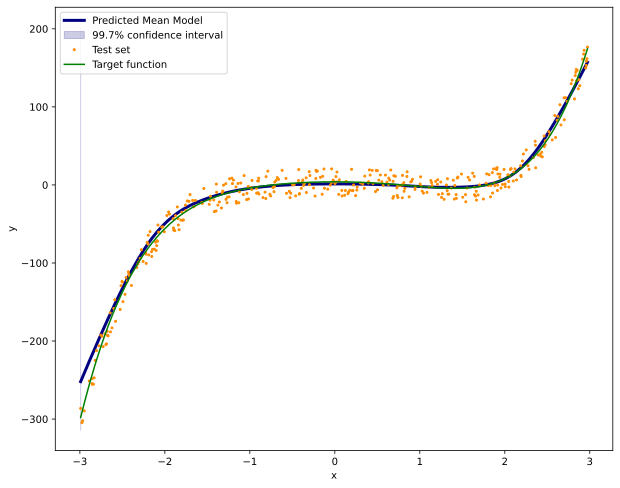

In [44]:
print(x_test.shape)
print(x_test[:, 1])

# print(clean_fx0(x_test[:, 0]).shape, type(clean_fx0(x_test[:])))
plt.figure(figsize=(10,8))
plt.plot(x_test[:, 0],mean_y0_results,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test[:, 0].T[0],mean_y0_results-3.0*std_y0_results,mean_y0_results+3.0*std_y0_results,alpha=0.2,color='navy',label='99.7% confidence interval')
plt.plot(x_test[:, 0],y_test[:, 0],'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_test[:, 0],clean_fx0(x_test[:, 0]),color='green',markersize=4,label='Target function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

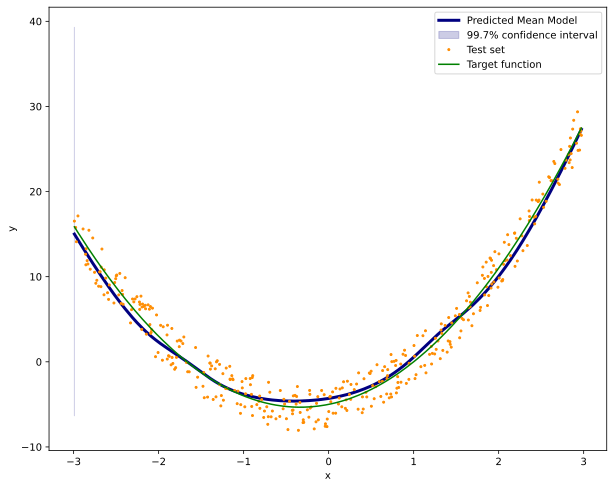

In [45]:
plt.figure(figsize=(10,8))
plt.plot(x_test[:, 1],mean_y1_results,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test[:, 1].T[0],mean_y1_results-3.0*std_y1_results,mean_y1_results+3.0*std_y1_results,alpha=0.2,color='navy',label='99.7% confidence interval')
plt.plot(x_test[:, 1],y_test[:, 1],'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_test[:, 1],clean_fx1(x_test[:, 1]),color='green',markersize=4,label='Target function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')